1. 必要的库

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2. 加载数据集

In [2]:
#定义图片、年龄、性别列表
images = []
ages = []
genders = []

#根据文件名中的”_“，逐个定义年龄和性别列表
for i in os.listdir('./UTKFace0/'):
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('./UTKFace0/' + i))

In [3]:
#创建一维数组，并分别命名
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

#以表格方式输出Images、Ages、Genders的信息
df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,100,1
...,...,...,...
337,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12,1
338,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12,1
339,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12,1
340,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12,1


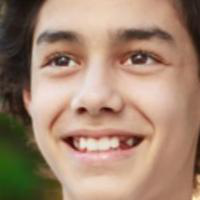

10 0


In [4]:
display(df['Images'][100])
print(df['Ages'][100], df['Genders'][100])

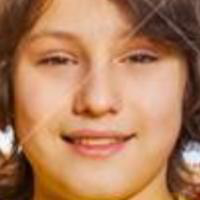

11 0


In [5]:
display(df['Images'][200])
print(df['Ages'][200], df['Genders'][200])

3. 数据预处理

C:\Users\Chen\AppData\Local\Temp\ipykernel_53308\2194303440.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)


<AxesSubplot:xlabel='Ages', ylabel='Density'>

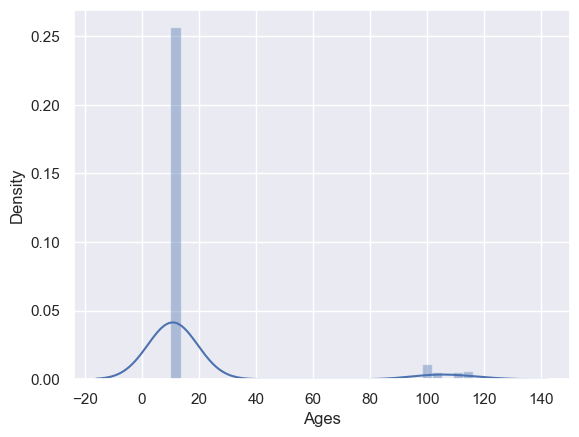

In [6]:
#切换到seaborn默认主题
sns.set_theme()
#kde：核密度图；bins：指定直方图显示矩形条的数量
sns.distplot(df['Ages'],kde=True, bins=30)

In [7]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
#frac：抽取行的比例
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]
#pd.concat()函数可以沿着指定的轴将多个dataframe或者series拼接到一起
df = pd.concat([df, under4s], ignore_index = True)

In [8]:
df = df[df['Ages'] < 80]

In [9]:
#删除所有性别=3的行
df = df[df['Genders'] != 3]

In [10]:
x = []
y = []

for i in range(len(df)):
    #iloc[]函数，对数据进行位置索引，从而在数据表中提取出相应的数据
    #重新定义图片尺寸为200*200；Image.ANTIALIAS：图片抗锯齿
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

C:\Users\Chen\AppData\Local\Temp\ipykernel_53308\3189104405.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
C:\Users\Chen\AppData\Local\Temp\ipykernel_53308\3189104405.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)


4. 切分训练测试集

In [11]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

5. 创建模型

In [12]:
#创建年龄判断模型
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(lr=0.0001))

#创建性别判断模型
genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

C:\Users\Chen\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


6. 训练模型

In [13]:
#rescale: 值将在执行其他处理前乘到整个图像上，我们的图像在RGB通道都是0~255的整数，这样的操作可能使图像的值过高或过低，所以我们将这个值定为0~1之间的数
#width_shift_range：浮点数，图片宽度的某个比例，数据提升时图片随机水平偏移的幅度。
#height_shift_range：浮点数，图片高度的某个比例，数据提升时图片随机竖直偏移的幅度。
#horizontal_flip：布尔值，进行随机水平翻转。随机的对图片进行水平翻转，这个参数适用于水平翻转不影响图片语义的时候。
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

#batch_size:表示单次传递给程序用以训练的数据(样本)个数
test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

#model.fit( ) ：将训练数据在模型中训练一定次数，返回loss和测量指标
#epochs：迭代次数，即全部样本数据将被“轮”多少次，轮完训练停止
#shuffle：打乱一个矩阵，也可以同时打乱两个变量组成的特征与标签
#validation_data：指定验证数据，该数据将覆盖validation_spilt设定的数据
history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

Epoch 1/50
8/8 [==============================] - 8s 880ms/step - loss: 44.3154 - val_loss: 13.5534
Epoch 2/50
8/8 [==============================] - 7s 873ms/step - loss: 16.0758 - val_loss: 6.2037
Epoch 3/50
8/8 [==============================] - 8s 971ms/step - loss: 10.9708 - val_loss: 9.9893
Epoch 4/50
8/8 [==============================] - 7s 874ms/step - loss: 8.7169 - val_loss: 5.5947
Epoch 5/50
8/8 [==============================] - 7s 907ms/step - loss: 8.5369 - val_loss: 5.7408
Epoch 6/50
8/8 [==============================] - 7s 855ms/step - loss: 9.0290 - val_loss: 5.6953
Epoch 7/50
8/8 [==============================] - 7s 868ms/step - loss: 8.2994 - val_loss: 4.7874
Epoch 8/50
8/8 [==============================] - 7s 915ms/step - loss: 8.6078 - val_loss: 4.8340
Epoch 9/50
8/8 [==============================] - 7s 879ms/step - loss: 8.2969 - val_loss: 4.2220
Epoch 10/50
8/8 [==============================] - 8s 981ms/step - loss: 7.9106 - val_loss: 4.4445
Epoch 11/50
8/8

In [14]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

Epoch 1/50
4/4 [==============================] - 9s 2s/step - loss: 0.7132 - accuracy: 0.5081 - val_loss: 0.6998 - val_accuracy: 0.5161
Epoch 2/50
4/4 [==============================] - 8s 2s/step - loss: 0.6826 - accuracy: 0.5444 - val_loss: 0.6854 - val_accuracy: 0.6290
Epoch 3/50
4/4 [==============================] - 8s 2s/step - loss: 0.6935 - accuracy: 0.5323 - val_loss: 0.6840 - val_accuracy: 0.5161
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 0.6881 - accuracy: 0.5645 - val_loss: 0.6780 - val_accuracy: 0.6613
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 0.6652 - accuracy: 0.6210 - val_loss: 0.6740 - val_accuracy: 0.6452
Epoch 6/50
4/4 [==============================] - 8s 2s/step - loss: 0.6615 - accuracy: 0.6048 - val_loss: 0.6692 - val_accuracy: 0.6613
Epoch 7/50
4/4 [==============================] - 8s 2s/step - loss: 0.6527 - accuracy: 0.6250 - val_loss: 0.6653 - val_accuracy: 0.6774
Epoch 8/50
4/4 [=========================

7.评估模型

In [15]:
#定义处理和预测函数
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            #crop()：图片裁剪函数
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

预测


1/1 [==============================] - ETA: 0s

C:\Users\Chen\AppData\Local\Temp\ipykernel_53308\2307616649.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize((200,200), Image.ANTIALIAS)


1/1 [==============================] - 0s 92ms/step
Age: 11 
 Gender: female


C:\Users\Chen\AppData\Local\Temp\ipykernel_53308\2307616649.py:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  return im.resize((300,300), Image.ANTIALIAS)


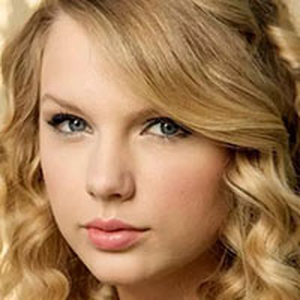

In [16]:
process_and_predict('./Face/Taylor.jpg')